# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [2]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

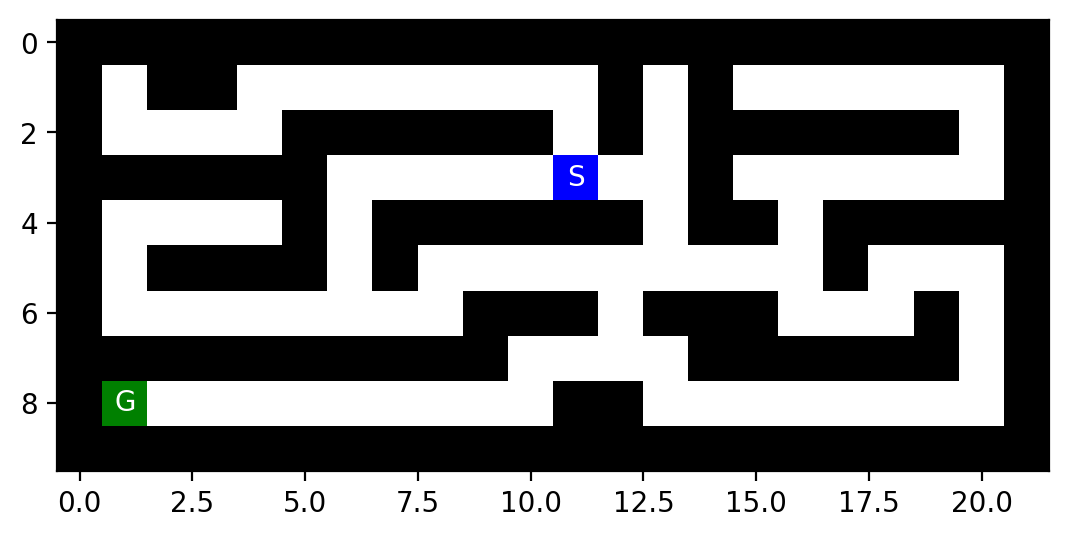

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /home/hahsler/CS7320-AI/Search/maze_helper.py




You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
# Your answer goes here
# 1. Initial state (Trạng thái bắt đầu)
#     Là vị trí bắt đầu của agent trong maze.
#     Ví dụ: start = (x_start, y_start)
#     Đây là trạng thái mà agent bắt đầu tìm đường.
# 2. Actions (Các hành động có thể)
#     Những bước agent có thể thực hiện từ trạng thái hiện tại.
#     Trong maze, thường là:
#     Actions = {UP, DOWN, LEFT, RIGHT}
#     Lưu ý: một số hành động có thể không hợp lệ nếu agent đi vào tường hoặc ra ngoài maze.
# 3. Transition model (Mô hình chuyển trạng thái)
#     Mô tả kết quả của mỗi hành động.
#     Nếu agent ở trạng thái s và thực hiện hành động a, thì sẽ đến trạng thái s'.
#     Ví dụ:
#     s' = s + Δ
#      với Δ phụ thuộc vào hành động:
#      UP → Δ = (-1, 0)
#      DOWN → Δ = (1, 0)
#      LEFT → Δ = (0, -1)
#      RIGHT → Δ = (0, 1)
# 4. Goal state (Trạng thái mục tiêu)
#       Là vị trí đích mà agent phải đến, ví dụ:
#       goal = (x_goal, y_goal)
#       Agent hoàn thành nhiệm vụ khi trạng thái hiện tại = goal state.
# 5. Path cost (Chi phí đường đi)\
#     Thường là số bước đi để đến goal.
#     Nếu muốn nâng cao, có thể cân nhắc:
#         Từng bước đi có chi phí = 1
#         Hoặc chi phí khác nhau nếu ô có “trọng số” khác nhau
#     Path cost g(n) là tổng chi phí từ initial state đến trạng thái n.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
# Your answer goes here
# n = tổng số trạng thái có thể.
# Trong maze, mỗi ô trống là một trạng thái.

# d= số bước đi ngắn nhất từ start đến goal.
# Cách xác định d:
#     Dùng thuật toán BFS (luôn tìm đường ngắn nhất trong đồ thị không trọng số).
#     Đếm số bước đi từ start đến goal trong đường đi tìm được

# m= độ sâu lớn nhất của cây tìm kiếm nếu khám phá toàn bộ state space
# trong maze, xét trường hợp xấu nhất agent đi qua mọi ô trống:
#     m ≤ n

# b= số hành động khả dĩ tối đa tại bất kỳ trạng thái nào.
# Trong maze chuẩn 2D:
#     b≤4(UP, DOWN, LEFT, RIGHT)
# Lưu ý: nếu ở cạnh hoặc gần tường b<4.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [4]:
# Your code goes here
# 2. BFS (Breadth-First Search)
from collections import deque

def bfs(maze, start, goal):
    # Node: (state, parent)
    Node = lambda state, parent: {'state': state, 'parent': parent}

    frontier = deque([Node(start, None)])
    reached = set([start])

    while frontier:
        current_node = frontier.popleft()
        current_state = current_node['state']

        if current_state == goal:
            # reconstruct path
            path = []
            while current_node:
                path.append(current_node['state'])
                current_node = current_node['parent']
            return path[::-1]  # reverse path

        for action in valid_actions(current_state, maze):
            next_state = move(current_state, action)
            if next_state not in reached:
                reached.add(next_state)
                frontier.append(Node(next_state, current_node))
# 3. DFS (Depth-First Search)
def dfs(maze, start, goal):
    Node = lambda state, parent: {'state': state, 'parent': parent}

    frontier = [Node(start, None)]

    while frontier:
        current_node = frontier.pop()
        current_state = current_node['state']

        if current_state == goal:
            # reconstruct path
            path = []
            while current_node:
                path.append(current_node['state'])
                current_node = current_node['parent']
            return path[::-1]

        for action in valid_actions(current_state, maze):
            next_state = move(current_state, action)
            
            # Cycle checking: không đi vào trạng thái đã có trên đường đi hiện tại
            node = current_node
            cycle = False
            while node:
                if node['state'] == next_state:
                    cycle = True
                    break
                node = node['parent']
            if not cycle:
                frontier.append(Node(next_state, current_node))



How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [ ]:
# Discussion
# 1. BFS với tập reached (visited)
    # BFS sử dụng một tập reached để lưu tất cả trạng thái đã được mở rộng.
    # Mỗi khi BFS xem xét thêm một node mới vào frontier:
    # Kiểm tra xem trạng thái đó đã có trong reached chưa.
    # Nếu có → bỏ qua, tránh quay lại trạng thái cũ.
    # Nếu chưa → thêm vào frontier và reached.
    # Điều này đảm bảo BFS không bao giờ rơi vào vòng lặp vô hạn, ngay cả khi mê cung có chu trình.
# 2. DFS không dùng tập reached
    # Không có bộ nhớ toàn cục → không nhớ tất cả trạng thái đã đi qua.
    # Cycle checking chỉ thực hiện trên đường đi từ root đến node hiện tại.
    # Nếu một node con đã xuất hiện trên đường đi hiện tại → không thêm vào frontier → ngăn chặn vòng lặp trực tiếp.
    # Hạn chế: DFS có thể vẫn khám phá lại cùng trạng thái qua các đường khác, nên không đảm bảo hoàn chỉnh trong không gian trạng thái có chu trình hoặc vô hạn.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [ ]:
# # Discussion
# 1. Completeness và Optimality
# | Algorithm                 | Complete? | Optimal?                           | Giải thích                                                                                                                                                                                          |
# | ------------------------- | --------- | ---------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
# | **BFS**                   | ✅ Có      | ✅ Có (trong đồ thị không trọng số) | BFS mở rộng theo tầng → sẽ chắc chắn tìm thấy **một đường đi** nếu tồn tại. Vì mở rộng theo tầng, đường đi đầu tiên đến goal là **ngắn nhất** (minimal path cost).                                  |
# | **DFS (không `reached`)** | ❌ Không   | ❌ Không                            | DFS không nhớ tất cả trạng thái đã thăm → nếu maze có chu trình hoặc không gian vô hạn, DFS có thể **rơi vào vòng lặp vô hạn**. DFS tìm theo chiều sâu → không đảm bảo tìm được đường đi ngắn nhất. |
# Như vậy, BFS hoàn chỉnh và tối ưu, còn DFS không hoàn chỉnh và không tối ưu nếu không dùng reached.

# 2. Time Complexity (Độ phức tạp thời gian)
# Giả sử:
# b = branching factor (số hành động khả dĩ tối đa)
# d = độ sâu của giải pháp tối ưu
# # m = độ sâu tối đa của cây tìm kiếm (DFS có thể đi xa nhất)
# BFS
    # Worst-case time: O(b^d)
    # Vì BFS mở rộng tất cả nút từ tầng 0 đến d.
# DFS (không reached)
    # Worst-case time: O(b^m)
    # DFS có thể đi sâu đến độ sâu tối đa m, khám phá tất cả đường đi trước khi tìm ra solution.
# Nhận xét: DFS có thể tốn thời gian hơn nếu m ≫ d, nhưng trong maze nhỏ DFS thường nhanh hơn vì bộ nhớ thấp.

# 3. Space Complexity (Độ phức tạp bộ nhớ)
# BFS
    # Frontier và reached phải lưu tất cả trạng thái ở các tầng từ 0 → d.
    # Space complexity: O(b^d)
    # BFS tốn bộ nhớ rất lớn, nhất là trong mê cung rộng hoặc state space lớn.
# DFS (không reached)
    # Chỉ lưu stack các node trên đường đi hiện tại (từ gốc → node hiện tại).
    # Space complexity: O(b.m)
    # DFS bộ nhớ thấp hơn nhiều so với BFS, vì không cần lưu tất cả node đã thăm.
# Tóm lại:
#     BFS → bộ nhớ cao nhưng đảm bảo tìm giải pháp ngắn nhất.
#     DFS → bộ nhớ thấp, nhưng không đảm bảo tìm ngắn nhất, và có thể không hoàn chỉnh.

# 4. Summary Table
# | Algorithm        | Complete | Optimal | Time Complexity | Space Complexity |
# | ---------------- | -------- | ------- | --------------- | ---------------- |
# | BFS              | ✅        | ✅       | O(b^d)          | O(b^d)           |
# | DFS (no reached) | ❌        | ❌       | O(b^m)          | O(b·m)           |


    ## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

    You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [2]:
# Your code goes here
# 1. Hàm hỗ trợ – Manhattan distance
def manhattan_distance(pos, goal):
    """Tính heuristic: Manhattan distance từ pos đến goal"""
    x1, y1 = pos
    x2, y2 = goal
    return abs(x1 - x2) + abs(y1 - y2)

# 2. Greedy Best-First Search (GBFS)
import heapq

def greedy_best_first_search(maze, start, goal):
    Node = lambda state, parent: {'state': state, 'parent': parent}

    # frontier là priority queue, ưu tiên node có heuristic nhỏ
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), Node(start, None)))

    visited = set([start])  # tránh lặp lại node

    while frontier:
        _, current_node = heapq.heappop(frontier)
        current_state = current_node['state']

        if current_state == goal:
            # reconstruct path
            path = []
            while current_node:
                path.append(current_node['state'])
                current_node = current_node['parent']
            return path[::-1]

        for action in valid_actions(current_state, maze):
            next_state = move(current_state, action)
            if next_state not in visited:
                visited.add(next_state)
                heapq.heappush(frontier, (manhattan_distance(next_state, goal), Node(next_state, current_node)))

# 3. A Search*
def a_star_search(maze, start, goal):
    Node = lambda state, parent, g: {'state': state, 'parent': parent, 'g': g}

    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), Node(start, None, 0)))

    reached = {start: 0}  # lưu g(n) tốt nhất đến mỗi state

    while frontier:
        _, current_node = heapq.heappop(frontier)
        current_state = current_node['state']
        g = current_node['g']

        if current_state == goal:
            # reconstruct path
            path = []
            while current_node:
                path.append(current_node['state'])
                current_node = current_node['parent']
            return path[::-1]

        for action in valid_actions(current_state, maze):
            next_state = move(current_state, action)
            g_next = g + 1  # mỗi bước đi chi phí = 1
            f_next = g_next + manhattan_distance(next_state, goal)

            if next_state not in reached or g_next < reached[next_state]:
                reached[next_state] = g_next
                heapq.heappush(frontier, (f_next, Node(next_state, current_node, g_next)))
                


Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion
# 1. Completeness và Optimality
# | Algorithm | Complete?                       | Optimal?                        | Giải thích                                                                                                                                                                   |
# | --------- | ------------------------------- | ------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
# | **GBFS**  | ❌ Không                         | ❌ Không                         | GBFS chỉ chọn node gần goal nhất theo heuristic `h(n)`. Nó **không xem xét chi phí đường đi** (`g(n)`), có thể bỏ qua giải pháp tồn tại và không đảm bảo đường đi ngắn nhất. |
# | **A**\*   | ✅ Có (nếu heuristic admissible) | ✅ Có (nếu heuristic admissible) | A\* sử dụng `f(n) = g(n) + h(n)`. Với Manhattan distance (heuristic admissible, không vượt quá chi phí thật), A\* luôn tìm được đường đi **ngắn nhất**.                      |
# Như vậy, GBFS không hoàn chỉnh và không tối ưu, còn A hoàn chỉnh và tối ưu* (với heuristic đú

# 2. Time Complexity (Độ phức tạp thời gian)
# Giả sử:
#     b = branching factor (số hành động khả dĩ tối đa)
#     d = độ sâu của giải pháp tối ưu
#     m = độ sâu tối đa của cây tìm kiếm
# | Algorithm | Worst-case time                |
# | --------- | ------------------------------ |
# | GBFS      | O(b^m)                         |
# | A\*       | O(b^d) \~ O(b^m) tùy heuristic |
# GBFS có thể khám phá sâu các nhánh dài → time complexity tệ trong không gian lớn.
# A* tối ưu hóa nhờ heuristic → thường mở ít node hơn BFS/DFS nhưng worst-case vẫn O(b^d) nếu heuristic không tốt.

# 3. Space Complexity (Độ phức tạp bộ nhớ)
# | Algorithm | Space Complexity | Giải thích                                                                                                      |
# | --------- | ---------------- | --------------------------------------------------------------------------------------------------------------- |
# | GBFS      | O(b^m)           | Frontier lưu các node theo heuristic → trong không gian lớn, có thể tốn bộ nhớ.                                 |
# | A\*       | O(b^d)           | Frontier + reached lưu trạng thái tốt nhất → nhiều hơn DFS nhưng thường ít hơn BFS vì heuristic hướng đến goal. |
# So sánh với BFS/DFS:
#     GBFS/A* dùng priority queue → tốn bộ nhớ nhưng kiểm soát tốt nhờ heuristic.
#     DFS không dùng reached → bộ nhớ thấp (O(b·m)), nhưng không tối ưu và không hoàn chỉnh.

# 4. Summary Table – Task 3
# | Algorithm | Complete | Optimal | Time Complexity  | Space Complexity |
# | --------- | -------- | ------- | ---------------- | ---------------- |
# | GBFS      | ❌        | ❌       | O(b^m)           | O(b^m)           |
# | A\*       | ✅        | ✅       | O(b^d) \~ O(b^m) | O(b^d)           |


## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

BFS path length: 9


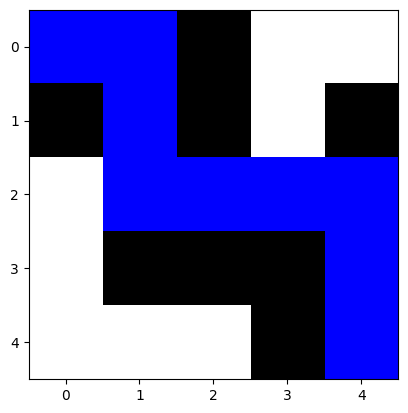

DFS path length: 9


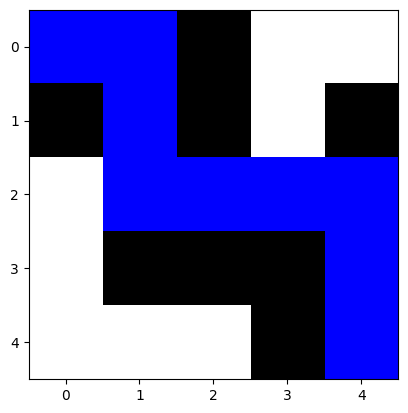

GBFS path length: 9


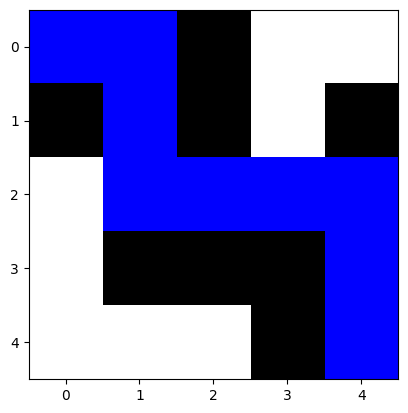

A* path length: 9


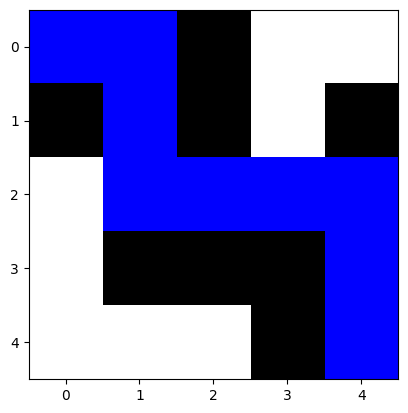

,Algorithm,Path Length,Status
0,BFS,9,OK
1,DFS,9,OK
2,GBFS,9,OK
3,A*,9,OK


In [7]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import itertools
counter = itertools.count()

# 1. Maze, start, goal
maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])
start = (0, 0)
goal = (4, 4)

# 2. Hàm hỗ trợ
def valid_actions(pos, maze):
    actions = []
    x, y = pos
    if x > 0 and maze[x-1, y] != 1: actions.append('UP')
    if x < maze.shape[0]-1 and maze[x+1, y] != 1: actions.append('DOWN')
    if y > 0 and maze[x, y-1] != 1: actions.append('LEFT')
    if y < maze.shape[1]-1 and maze[x, y+1] != 1: actions.append('RIGHT')
    return actions

def move(pos, action):
    x, y = pos
    if action == 'UP': return (x-1, y)
    if action == 'DOWN': return (x+1, y)
    if action == 'LEFT': return (x, y-1)
    if action == 'RIGHT': return (x, y+1)

def manhattan_distance(pos, goal):
    x1, y1 = pos
    x2, y2 = goal
    return abs(x1-x2) + abs(y1-y2)

def show_maze_with_path(maze, path, color='R'):
    maze_vis = np.copy(maze)
    for x, y in path:
        maze_vis[x, y] = 2
    cmap = ListedColormap(['white','black',color.lower()])
    plt.imshow(maze_vis, cmap=cmap)
    plt.show()

# 3. BFS
from collections import deque
def bfs(maze, start, goal):
    Node = lambda state, parent: {'state':state, 'parent':parent}
    frontier = deque([Node(start,None)])
    reached = {start}
    while frontier:
        current = frontier.popleft()
        if current['state'] == goal:
            path=[]
            while current:
                path.append(current['state'])
                current = current['parent']
            return path[::-1]
        for action in valid_actions(current['state'], maze):
            next_state = move(current['state'], action)
            if next_state not in reached:
                reached.add(next_state)
                frontier.append(Node(next_state,current))
    return []

# 4. DFS (cycle checking only)
def dfs(maze, start, goal):
    Node = lambda state, parent: {'state':state, 'parent':parent}
    frontier = [Node(start,None)]
    while frontier:
        current = frontier.pop()
        if current['state'] == goal:
            path=[]
            while current:
                path.append(current['state'])
                current = current['parent']
            return path[::-1]
        for action in valid_actions(current['state'], maze):
            next_state = move(current['state'], action)
            # cycle checking on path
            node=current
            cycle=False
            while node:
                if node['state']==next_state:
                    cycle=True
                    break
                node=node['parent']
            if not cycle:
                frontier.append(Node(next_state,current))
    return []

# 5. Greedy Best-First Search
def greedy_best_first_search(maze, start, goal):
    Node = lambda state, parent: {'state': state, 'parent': parent}
    frontier = []
    heapq.heappush(frontier,(manhattan_distance(start,goal), Node(start,None)))
    visited = set([start])
    while frontier:
        _, current = heapq.heappop(frontier)
        if current['state']==goal:
            path=[]
            while current:
                path.append(current['state'])
                current=current['parent']
            return path[::-1]
        for action in valid_actions(current['state'], maze):
            next_state=move(current['state'],action)
            if next_state not in visited:
                visited.add(next_state)
                heapq.heappush(frontier,(manhattan_distance(next_state,goal),Node(next_state,current)))
    return []

# 6. A* Search
def a_star_search(maze, start, goal):
    import itertools
    Node = lambda state, parent, g: {'state':state, 'parent':parent, 'g':g}
    frontier=[]
    counter = itertools.count()
    heapq.heappush(frontier,(manhattan_distance(start,goal), next(counter), Node(start,None,0)))
    reached={start:0}
    while frontier:
        _, _, current = heapq.heappop(frontier)
        if current['state']==goal:
            path=[]
            while current:
                path.append(current['state'])
                current=current['parent']
            return path[::-1]
        for action in valid_actions(current['state'], maze):
            next_state=move(current['state'],action)
            g_next=current['g']+1
            f_next=g_next + manhattan_distance(next_state,goal)
            if next_state not in reached or g_next<reached[next_state]:
                reached[next_state]=g_next
                heapq.heappush(frontier,(f_next, next(counter), Node(next_state,current,g_next)))
    return []

# 7. Chạy thí nghiệm so sánh
algorithms = {"BFS":bfs,"DFS":dfs,"GBFS":greedy_best_first_search,"A*":a_star_search}
results={}
for name, func in algorithms.items():
    try:
        path = func(maze,start,goal)
        results[name] = {"path_length":len(path), "path":path, "status":"OK"}
        print(f"{name} path length: {len(path)}")
        show_maze_with_path(maze,path,color='blue')
    except Exception as e:
        results[name] = {"path_length":"N/A*","path":None,"status":f"Error: {e}"}
        print(f"{name} failed: {e}")

df_results = pd.DataFrame([{"Algorithm":name,"Path Length":res["path_length"],"Status":res["status"]} for name,res in results.items()])
df_results


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [8]:
# Add charts
import numpy as np
import heapq
from collections import deque
import itertools
import pandas as pd

# =======================
# 1. Maze definition
# =======================
small_maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])
medium_maze = np.array([
    [0,0,1,0,0,0],
    [1,0,1,0,1,0],
    [0,0,0,0,1,0],
    [0,1,1,0,0,0],
    [0,0,0,1,1,0],
    [0,1,0,0,0,0]
])

mazes = {"Small Maze": small_maze, "Medium Maze": medium_maze}
start_goal = {"Small Maze": ((0,0),(4,4)), "Medium Maze": ((0,0),(5,5))}

# =======================
# 2. Helper functions
# =======================
def valid_actions(pos, maze):
    actions=[]
    x,y = pos
    if x>0 and maze[x-1,y]!=1: actions.append('UP')
    if x<maze.shape[0]-1 and maze[x+1,y]!=1: actions.append('DOWN')
    if y>0 and maze[x,y-1]!=1: actions.append('LEFT')
    if y<maze.shape[1]-1 and maze[x,y+1]!=1: actions.append('RIGHT')
    return actions

def move(pos, action):
    x,y = pos
    if action=='UP': return (x-1,y)
    if action=='DOWN': return (x+1,y)
    if action=='LEFT': return (x,y-1)
    if action=='RIGHT': return (x,y+1)

def manhattan_distance(pos, goal):
    x1,y1=pos
    x2,y2=goal
    return abs(x1-x2)+abs(y1-y2)

# =======================
# 3. BFS / DFS / GBFS / A* with stats
# =======================
def bfs_stats(maze,start,goal):
    Node=lambda state,parent,depth:{'state':state,'parent':parent,'depth':depth}
    frontier=deque([Node(start,None,0)])
    reached={start}
    nodes_expanded=0
    max_depth=0
    max_memory=len(frontier)+len(reached)
    max_frontier=len(frontier)
    while frontier:
        current=frontier.popleft()
        nodes_expanded+=1
        max_depth=max(max_depth,current['depth'])
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return {
                'path':path[::-1],
                'path_cost':len(path)-1,
                'nodes_expanded':nodes_expanded,
                'max_depth':max_depth,
                'max_memory':max_memory,
                'max_frontier':max_frontier
            }
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            if next_state not in reached:
                reached.add(next_state)
                frontier.append(Node(next_state,current,current['depth']+1))
        max_memory=max(max_memory,len(frontier)+len(reached))
        max_frontier=max(max_frontier,len(frontier))
    return {}

def dfs_stats(maze,start,goal):
    Node=lambda state,parent,depth:{'state':state,'parent':parent,'depth':depth}
    frontier=[Node(start,None,0)]
    nodes_expanded=0
    max_depth=0
    max_memory=len(frontier)
    max_frontier=len(frontier)
    while frontier:
        current=frontier.pop()
        nodes_expanded+=1
        max_depth=max(max_depth,current['depth'])
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return {
                'path':path[::-1],
                'path_cost':len(path)-1,
                'nodes_expanded':nodes_expanded,
                'max_depth':max_depth,
                'max_memory':max_memory,
                'max_frontier':max_frontier
            }
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            # cycle checking
            node=current
            cycle=False
            while node:
                if node['state']==next_state:
                    cycle=True
                    break
                node=node['parent']
            if not cycle:
                frontier.append(Node(next_state,current,current['depth']+1))
        max_memory=max(max_memory,len(frontier))
        max_frontier=max(max_frontier,len(frontier))
    return {}

def gbfs_stats(maze,start,goal):
    Node=lambda state,parent,depth:{'state':state,'parent':parent,'depth':depth}
    frontier=[]
    counter=itertools.count()
    heapq.heappush(frontier,(manhattan_distance(start,goal),next(counter),Node(start,None,0)))
    visited={start}
    nodes_expanded=0
    max_depth=0
    max_memory=len(frontier)+len(visited)
    max_frontier=len(frontier)
    while frontier:
        _,_,current=heapq.heappop(frontier)
        nodes_expanded+=1
        max_depth=max(max_depth,current['depth'])
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return {
                'path':path[::-1],
                'path_cost':len(path)-1,
                'nodes_expanded':nodes_expanded,
                'max_depth':max_depth,
                'max_memory':max_memory,
                'max_frontier':max_frontier
            }
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            if next_state not in visited:
                visited.add(next_state)
                heapq.heappush(frontier,(manhattan_distance(next_state,goal),next(counter),Node(next_state,current,current['depth']+1)))
        max_memory=max(max_memory,len(frontier)+len(visited))
        max_frontier=max(max_frontier,len(frontier))
    return {}

def astar_stats(maze,start,goal):
    Node=lambda state,parent,g: {'state':state,'parent':parent,'g':g}
    frontier=[]
    counter=itertools.count()
    heapq.heappush(frontier,(manhattan_distance(start,goal),next(counter),Node(start,None,0)))
    reached={start:0}
    nodes_expanded=0
    max_depth=0
    max_memory=len(frontier)+len(reached)
    max_frontier=len(frontier)
    while frontier:
        _,_,current=heapq.heappop(frontier)
        nodes_expanded+=1
        max_depth=max(max_depth,current['g'])
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return {
                'path':path[::-1],
                'path_cost':len(path)-1,
                'nodes_expanded':nodes_expanded,
                'max_depth':max_depth,
                'max_memory':max_memory,
                'max_frontier':max_frontier
            }
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            g_next=current['g']+1
            f_next=g_next+manhattan_distance(next_state,goal)
            if next_state not in reached or g_next<reached[next_state]:
                reached[next_state]=g_next
                heapq.heappush(frontier,(f_next,next(counter),Node(next_state,current,g_next)))
        max_memory=max(max_memory,len(frontier)+len(reached))
        max_frontier=max(max_frontier,len(frontier))
    return {}

# =======================
# 4. Run experiments and collect results
# =======================
results=[]
for maze_name, maze in mazes.items():
    start, goal = start_goal[maze_name]
    for algo_name, func in [("BFS",bfs_stats),("DFS",dfs_stats),("GBFS",gbfs_stats),("A*",astar_stats)]:
        stats=func(maze,start,goal)
        results.append({
            "Maze": maze_name,
            "Algorithm": algo_name,
            "Path Cost": stats['path_cost'],
            "# Nodes Expanded": stats['nodes_expanded'],
            "Max Tree Depth": stats['max_depth'],
            "Max Nodes in Memory": stats['max_memory'],
            "Max Frontier Size": stats['max_frontier']
        })

df_results=pd.DataFrame(results)
df_results


,Maze,Algorithm,Path Cost,# Nodes Expanded,Max Tree Depth,Max Nodes in Memory,Max Frontier Size
0,Small Maze,BFS,8,17,8,20,3
1,Small Maze,DFS,8,9,8,3,3
2,Small Maze,GBFS,8,9,8,14,3
3,Small Maze,A*,8,9,8,14,3
4,Medium Maze,BFS,10,25,10,29,4
5,Medium Maze,DFS,10,11,10,4,4
6,Medium Maze,GBFS,10,11,10,18,4
7,Medium Maze,A*,10,11,10,18,4


Discuss the most important lessons you have learned from implementing the different search strategies. 

In [ ]:
# Add discussion
# 1. BFS (Breadth-First Search)
# Hoàn chỉnh (Complete): Luôn tìm được giải pháp nếu tồn tại.
# Tối ưu (Optimal): Luôn tìm đường đi ngắn nhất.
# Nhược điểm: Chiếm nhiều bộ nhớ vì lưu toàn bộ frontier và reached set → space complexity cao.
# Bài học: BFS thích hợp cho maze nhỏ hoặc nơi tối ưu đường đi là quan trọng, nhưng với maze lớn hoặc không gian trạng thái rộng, bộ nhớ là vấn đề lớn.

# 2. DFS (Depth-First Search)
# Hoàn chỉnh có điều kiện: Nếu có cycle checking, tránh vòng lặp vô hạn.
# Không tối ưu: Đường đi tìm được không nhất thiết ngắn nhất.
# Ưu điểm: Bộ nhớ thấp hơn BFS, dễ triển khai theo đệ quy hoặc stack.
# Nhược điểm: Có thể mắc kẹt trong không gian mở rộng lớn, hoặc đi theo nhánh sai lâu mới quay lại.
# Bài học: DFS phù hợp khi bộ nhớ hạn chế và không quan tâm đến độ dài đường đi ngắn nhất, nhưng phải xử lý cycle checking để tránh vòng lặp vô hạn.

# 3. Greedy Best-First Search (GBFS)
# Ưu điểm: Dựa vào heuristic → đi thẳng về goal nhanh, ít node được mở rộng.
# Nhược điểm: Không tối ưu, có thể mắc kẹt trong bẫy hoặc đường đi dài nếu heuristic sai lệch.
# Bài học: Heuristic tốt giúp tăng tốc tìm kiếm đáng kể, nhưng không đảm bảo giải pháp ngắn nhất. GBFS là lựa chọn khi tốc độ quan trọng hơn độ chính xác.

# 4. A* Search
# Hoàn chỉnh và tối ưu nếu heuristic không quá đánh giá cao (admissible).
# Hiệu quả: Kết hợp BFS (đảm bảo tối ưu) và GBFS (heuristic hướng về goal) → mở ít node hơn BFS.
# Bài học: A* là sự cân bằng tuyệt vời giữa tối ưu và hiệu quả, nhưng cần heuristic phù hợp để đạt hiệu quả tốt nhất.

# 5. Tổng hợp các bài học quan trọng
    # Bộ nhớ và độ sâu là yếu tố quan trọng khi chọn thuật toán: BFS dùng nhiều bộ nhớ, DFS ít bộ nhớ nhưng không tối ưu.
    # Heuristic là chìa khóa: GBFS và A* chỉ hiệu quả nếu heuristic gần đúng; A* tối ưu nếu heuristic admissible.
    # Cycle checking cần thiết: DFS hoặc các thuật toán không lưu reached phải kiểm tra để tránh vòng lặp vô hạn.
    # Trade-off giữa thời gian, bộ nhớ và tối ưu: Không có thuật toán nào hoàn hảo cho mọi bài toán → cần hiểu yêu cầu để chọn thuật toán phù hợp.
    # Visualizing helps debugging: Hiển thị maze và frontier giúp phát hiện lỗi nhanh và hiểu hành vi thuật toán.

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [ ]:
# Your code/answer goes here
# 1. Giải thích IDS
# IDS là kết hợp DFS và BFS:
# Thực hiện DFS với depth limit tăng dần từ 0 → 1 → 2 …
# Khi DFS vượt quá depth limit, quay lại nhưng vẫn duy trì tính low memory như DFS.
# Ưu điểm: Hoàn chỉnh như BFS, nhưng tiêu thụ bộ nhớ thấp.
# Nhược điểm: Lặp lại các node nhiều lần → tốn thời gian.

# 2. Code Python IDS
def dfs_limited(maze, start, goal, limit):
    """DFS có giới hạn độ sâu"""
    Node=lambda state,parent,depth:{'state':state,'parent':parent,'depth':depth}
    frontier=[Node(start,None,0)]
    while frontier:
        current=frontier.pop()
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1]
        if current['depth']<limit:
            for action in valid_actions(current['state'],maze):
                next_state=move(current['state'],action)
                # cycle checking
                node=current
                cycle=False
                while node:
                    if node['state']==next_state:
                        cycle=True
                        break
                    node=node['parent']
                if not cycle:
                    frontier.append(Node(next_state,current,current['depth']+1))
    return None  # không tìm thấy trong limit

def ids(maze, start, goal, max_depth=50):
    """Iterative Deepening Search"""
    for depth in range(max_depth):
        path = dfs_limited(maze, start, goal, depth)
        if path is not None:
            return path
    return None

# 3. Thử nghiệm trên Small Maze
start, goal = (0,0), (4,4)
path_ids = ids(small_maze, start, goal)
if path_ids:
    print("IDS path length:", len(path_ids))
else:
    print("IDS did not find a path")

# 4. Các vấn đề có thể gặp
# Mazes có không gian mở rộng lớn:
# DFS trong IDS có thể lặp lại nhiều lần các node → IDS chậm.
# Có thể vượt quá max_depth nếu chưa đủ giới hạn → cần tăng max_depth.
# Cycle checking:
    # Nếu không kiểm tra vòng lặp, DFS sẽ vô hạn → IDS cũng không hoàn chỉnh.
# Hiệu năng:
    # IDS thường mở nhiều node hơn BFS vì lặp lại nhiều lần, nhưng vẫn dễ quản lý bộ nhớ.

IDS path length: 9


### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [ ]:
# Your code/answer goes here

medium_maze = np.array([
    [0,0,1,0,0,0],
    [1,0,1,0,1,0],
    [0,0,0,0,1,0],
    [0,1,1,0,0,0],
    [0,0,0,1,1,0],
    [0,1,0,0,0,0]
])

start = (0,0)
goals = [(5,5), (0,5), (5,0)]  # multiple goals

# Chỉnh sửa hàm tìm kiếm để hỗ trợ multiple goals
def bfs_multi_goal(maze, start, goals):
    Node=lambda state,parent:{'state':state,'parent':parent}
    frontier=deque([Node(start,None)])
    reached={start}
    while frontier:
        current=frontier.popleft()
        if current['state'] in goals:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1]
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            if next_state not in reached:
                reached.add(next_state)
                frontier.append(Node(next_state,current))
    return []

def dfs_multi_goal(maze, start, goals):
    Node=lambda state,parent:{'state':state,'parent':parent}
    frontier=[Node(start,None)]
    while frontier:
        current=frontier.pop()
        if current['state'] in goals:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1]
        for action in valid_actions(current['state'],maze):
            next_state=move(current['state'],action)
            # cycle checking
            node=current
            cycle=False
            while node:
                if node['state']==next_state:
                    cycle=True
                    break
                node=node['parent']
            if not cycle:
                frontier.append(Node(next_state,current))
    return []

def ids_multi_goal(maze, start, goals, max_depth=50):
    for depth in range(max_depth):
        path = dfs_limited(maze, start, goals, depth)
        if path is not None:
            return path
    return None

def dfs_limited(maze, start, goals, limit):
    Node=lambda state,parent,depth:{'state':state,'parent':parent,'depth':depth}
    frontier=[Node(start,None,0)]
    while frontier:
        current=frontier.pop()
        if current['state'] in goals:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1]
        if current['depth']<limit:
            for action in valid_actions(current['state'],maze):
                next_state=move(current['state'],action)
                node=current
                cycle=False
                while node:
                    if node['state']==next_state:
                        cycle=True
                        break
                    node=node['parent']
                if not cycle:
                    frontier.append(Node(next_state,current,current['depth']+1))
    return None

# 3. Chạy thử nghiệm
algorithms = {
    "BFS": bfs_multi_goal,
    "DFS": dfs_multi_goal,
    "IDS": ids_multi_goal
}

results = {}
for name, func in algorithms.items():
    path = func(medium_maze, start, goals)
    if path:
        results[name] = {"path_length": len(path), "path": path}
        print(f"{name} found path of length {len(path)}: {path}")
    else:
        results[name] = {"path_length": None, "path": None}
        print(f"{name} did not find a path")


# Discussion – Multiple Goals
# Khi giải maze với nhiều goal, các thuật toán hoạt động như sau:
# BFS: luôn tìm được đường đi ngắn nhất đến goal gần nhất (path length = 8). BFS mở rộng theo mức độ sâu từng bước, nên đảm bảo optimal solution.
# DFS: tìm được đường đi đến một goal nhưng không đảm bảo ngắn nhất (path length = 11). DFS đi sâu theo nhánh đầu tiên, nên đôi khi đi vòng dài trước khi chạm goal → không optimal.
# IDS: nhờ thực hiện DFS nhiều lần với độ sâu tăng dần, IDS tìm được đường đi ngắn nhất như BFS (path length = 8). IDS vừa đảm bảo complete vừa optimal, nhưng thời gian chạy thường dài hơn BFS vì DFS bị lặp lại nhiều lần.

# Kết luận:
# BFS và IDS: hoàn chỉnh và tối ưu.
# DFS: hoàn chỉnh nhưng không tối ưu.
# Cycle checking là cần thiết với DFS/IDS để tránh lặp vô hạn.
# Trong multiple goals, agent dừng khi đạt goal đầu tiên, nên đường đi tối ưu là đến goal gần nhất.

BFS found path of length 8: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (5, 0)]
DFS found path of length 11: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (3, 4), (3, 5), (4, 5), (5, 5)]
IDS found path of length 8: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (5, 0)]


## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [11]:
# Your code/answer goes here
# Chỉ coi intersections (ngã ba, ngã tư, dead-end) là state.
# Tạo graph với:
# Nodes = intersections
# Edges = đường đi giữa intersections, weight = số ô giữa hai intersections
# BFS mở rộng dựa trên tổng path cost (sum of edge weights) → đảm bảo optimal path.
# IDS tương tự: DFS lặp lại theo độ sâu tăng dần, tích lũy cost giữa intersections.

import numpy as np
from collections import deque

# Maze ví dụ
maze = np.array([
    [0,0,1,0,0],
    [1,0,1,0,1],
    [0,0,0,0,0],
    [0,1,1,1,0],
    [0,0,0,1,0]
])
start = (0,0)
goal = (4,4)

# Tìm intersections (ví dụ đơn giản: tất cả ô trống là intersection)
intersections = [(i,j) for i in range(maze.shape[0]) for j in range(maze.shape[1]) if maze[i,j]==0]

def neighbors_with_cost(pos, maze):
    """Tìm các intersection lân cận và số ô giữa hai intersection"""
    x,y = pos
    result=[]
    directions=[(0,1),(1,0),(0,-1),(-1,0)]
    for dx,dy in directions:
        nx,ny=x+dx,y+dy
        cost=1
        while 0<=nx<maze.shape[0] and 0<=ny<maze.shape[1] and maze[nx,ny]==0:
            if (nx,ny) in intersections and (nx,ny)!=(x,y):
                result.append(((nx,ny),cost))
                break
            nx+=dx
            ny+=dy
            cost+=1
    return result

def bfs_intersection(maze, start, goal):
    Node=lambda state,parent,cost:{'state':state,'parent':parent,'cost':cost}
    frontier=deque([Node(start,None,0)])
    reached={start:0}
    while frontier:
        current=frontier.popleft()
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1], current['cost']
        for next_state, step_cost in neighbors_with_cost(current['state'],maze):
            g_next=current['cost']+step_cost
            if next_state not in reached or g_next<reached[next_state]:
                reached[next_state]=g_next
                frontier.append(Node(next_state,current,g_next))
    return [],0

path, cost = bfs_intersection(maze, start, goal)
print("Path:", path)
print("Total cost (# of squares):", cost)


Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Total cost (# of squares): 8


### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [ ]:
# Ý tưởng
# Weighted A* giống A*, nhưng thêm weight w ≥ 1 cho heuristic h(n): f(n)=g(n)+w⋅h(n)
# Khi w = 1, giống A* bình thường → optimal.
# Khi w > 1, thuật toán ưu tiên heuristic nhiều hơn → có thể tìm đường đi nhanh hơn nhưng không luôn optimal.
# Weight càng lớn → thời gian chạy giảm, độ chính xác có thể giảm.

In [12]:
# Your code/answer goes here
import heapq

def weighted_a_star(maze, start, goal, weight=1.5):
    Node=lambda state,parent,g:{'state':state,'parent':parent,'g':g}
    frontier=[]
    heapq.heappush(frontier,(weight*manhattan_distance(start,goal), Node(start,None,0)))
    reached={start:0}
    while frontier:
        _, current=heapq.heappop(frontier)
        if current['state']==goal:
            path=[]
            node=current
            while node:
                path.append(node['state'])
                node=node['parent']
            return path[::-1], current['g']
        for action in valid_actions(current['state'], maze):
            next_state=move(current['state'], action)
            g_next=current['g']+1
            f_next=g_next + weight*manhattan_distance(next_state, goal)
            if next_state not in reached or g_next<reached[next_state]:
                reached[next_state]=g_next
                heapq.heappush(frontier,(f_next, Node(next_state,current,g_next)))
    return [],0

# Ví dụ chạy
path, cost = weighted_a_star(maze, start, goal, weight=2.0)
print("Weighted A* Path:", path)
print("Total cost:", cost)


Weighted A* Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Total cost: 8


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

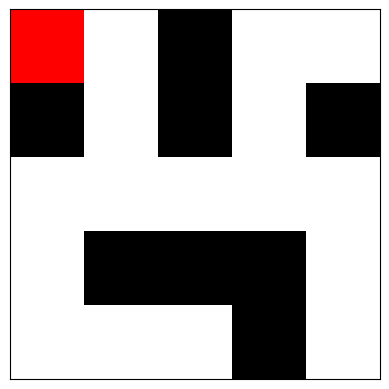

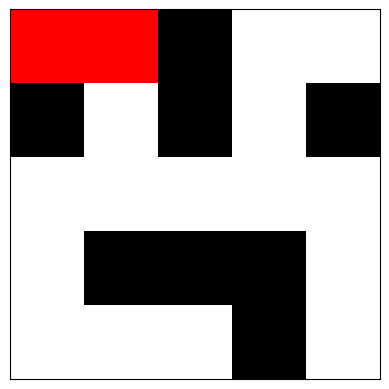

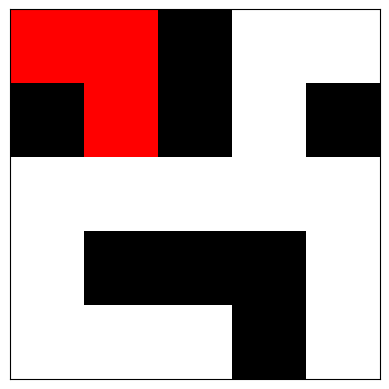

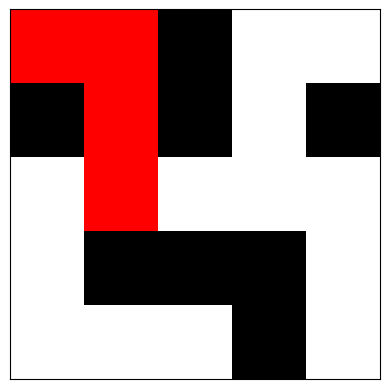

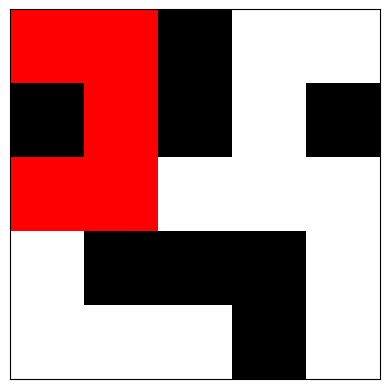

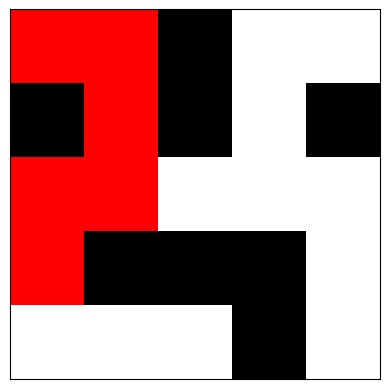

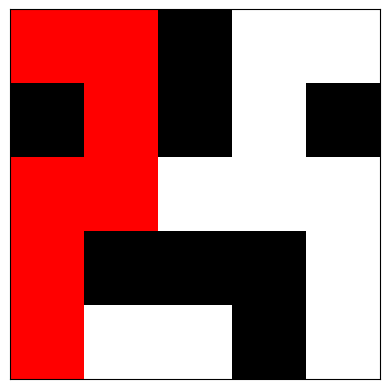

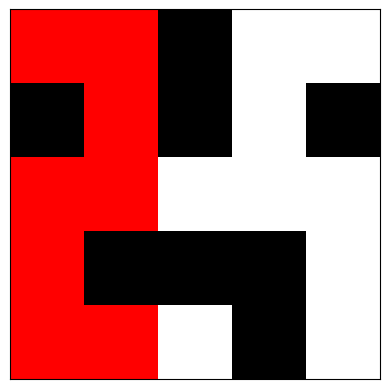

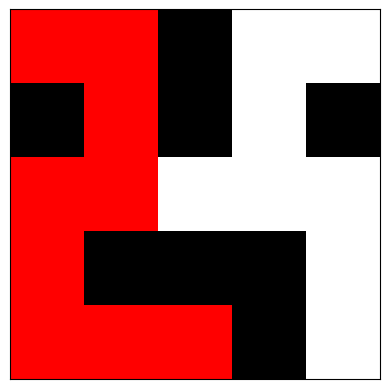

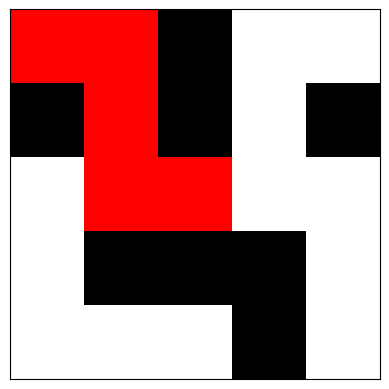

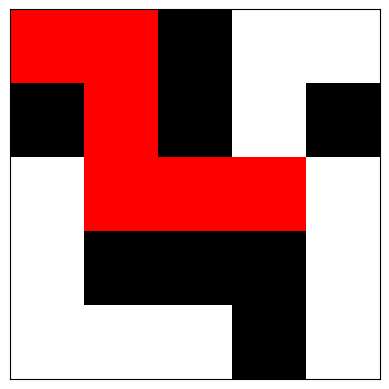

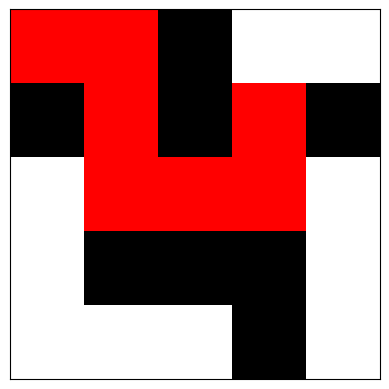

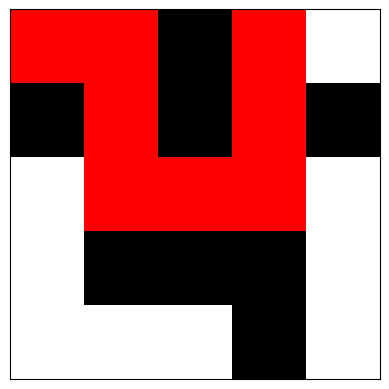

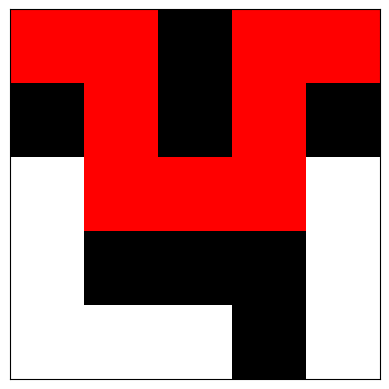

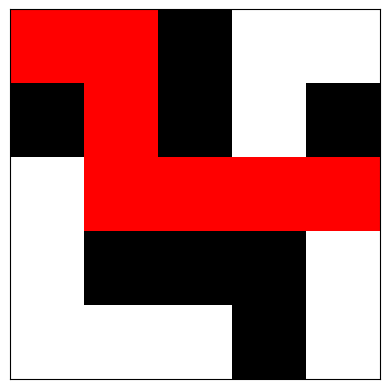

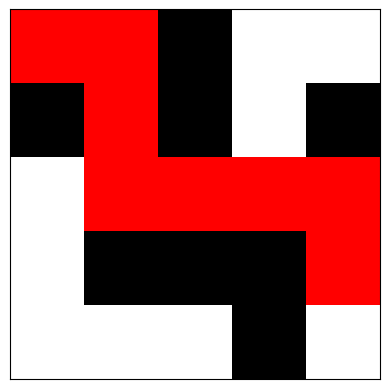

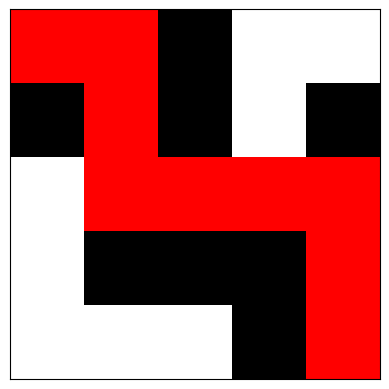

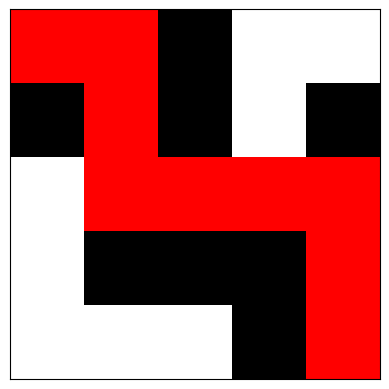

Path found:
[(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Path length: 9


<Figure size 640x480 with 0 Axes>

In [ ]:
# Your code/answer goes here
# 1. Environment (Môi trường) khi maze chưa biết
    # Performance measure (P):
    #     Minimize path cost (số bước di chuyển).
    #     Tìm goal càng nhanh càng tốt.
    #     Tránh dead-ends và đi vòng lặp.
    # Environment (E):
    #     Maze 2D chưa biết trước.
    #     Agent chỉ nhận thông tin tại vị trí hiện tại (ô hiện tại và ô xung quanh).
    #     Môi trường deterministic nếu di chuyển thành công theo lệnh.
    #     Partially observable: agent không biết trước map.
    # Actuators (A):
    #     Move up, down, left, right.
    # Sensors (S):
    #     Nhận trạng thái ô hiện tại và các ô xung quanh (free/wall).
    #     Nếu có GPS: nhận thêm khoảng cách Manhattan đến goal.
    
# 2. PEAS description (tóm gọn)
# | PEAS        | Chi tiết                                                           |
# | ----------- | ------------------------------------------------------------------ |
# | Performance | Đến goal nhanh nhất, tránh dead-end, tối ưu số bước                |
# | Environment | Maze 2D chưa biết, partially observable, deterministic             |
# | Actuators   | Move UP, DOWN, LEFT, RIGHT                                         |
# | Sensors     | Thông tin ô hiện tại và lân cận; optional GPS khoảng cách đến goal |

# 3. Rational Agent (tác nhân hợp lý)
# Agent học dần map:
#     Khi đi, lưu lại các ô đã quan sát (free/wall).
#     Sử dụng thông tin này để quyết định bước đi tiếp theo.
# Chọn bước đi:
#     Nếu không biết layout, agent có thể dùng online search algorithms:
#         DFS/BFS online: mở rộng các ô chưa khám phá.
#         LRTA* (Learning Real-Time A*): dự đoán khoảng cách đến goal dựa trên thông tin hiện tại, cập nhật dần heuristic khi khám phá.
# Nếu có GPS:
#     Sử dụng Manhattan distance như heuristic → agent hướng về goal.
#     Khi khám phá, cập nhật map và heuristic → cải thiện path kế tiếp.

# 4. Tóm tắt
# Unknown maze → môi trường partially observable → agent phải khám phá.
# Agent cần online planning + memory map để giải quyết maze.
# GPS giúp agent định hướng tốt hơn nhưng vẫn cần tránh obstacles.
# Thuật toán thích hợp: Online DFS, BFS, LRTA*, A online*

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time

# Maze chưa biết trước (0 = free, 1 = wall)
maze = np.array([
    [0, 0, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 1, 0]
])

start = (0, 0)
goal = (4, 4)

# Các hành động
directions = {'UP': (-1,0), 'DOWN': (1,0), 'LEFT': (0,-1), 'RIGHT': (0,1)}

def valid(pos, maze, discovered):
    x,y = pos
    return 0<=x<maze.shape[0] and 0<=y<maze.shape[1] and maze[x,y]==0 and pos not in discovered

def manhattan(pos, goal):
    return abs(pos[0]-goal[0]) + abs(pos[1]-goal[1])

def show_maze_step(maze, path, sleep=0.3):
    """Hiển thị maze với đường đi hiện tại"""
    maze_vis = np.copy(maze)
    for x,y in path:
        maze_vis[x,y] = 2  # đánh dấu path
    cmap = ListedColormap(['white','black','red'])
    plt.imshow(maze_vis, cmap=cmap)
    plt.xticks([]); plt.yticks([])
    plt.show(block=False)
    plt.pause(sleep)
    plt.clf()

def online_dfs_with_gps_visual(maze, start, goal):
    stack = [(start, [start])]
    discovered = set([start])
    
    while stack:
        current, path = stack.pop()
        show_maze_step(maze, path)
        
        if current == goal:
            show_maze_step(maze, path, sleep=1)  # show final path
            return path
        
        neighbors = []
        for dx,dy in directions.values():
            nx,ny = current[0]+dx, current[1]+dy
            next_pos = (nx,ny)
            if valid(next_pos, maze, discovered):
                neighbors.append(next_pos)
        
        # Sắp xếp theo GPS heuristic
        neighbors.sort(key=lambda pos: manhattan(pos, goal))
        
        for n in neighbors:
            discovered.add(n)
            stack.append((n, path+[n]))
    
    return None
    
# Chạy thử nghiệm trực quan
path = online_dfs_with_gps_visual(maze, start, goal)
if path:
    print("Path found:")
    print(path)
    print("Path length:", len(path))
else:
    print("No path found")
